## Import lib and read date

In [3]:
import pandas as pd

fp = "data/2315676.txt"
data = pd.read_csv(
    fp,
    delim_whitespace=True,
    usecols=["DATE", "TAVG", "TMAX", "TMIN"], # use these cols
    skiprows=[1], # skip second row
    na_values=[-9999], # nan value
    parse_dates=['DATE'], # parse date
    index_col=['DATE'] # set date as index
)

In [4]:
data.head()

,TAVG,TMAX,TMIN
DATE,,,
1908-01-01,NaN,2.0,-37.0
1908-01-02,NaN,6.0,-26.0
1908-01-03,NaN,7.0,-27.0
1908-01-04,NaN,-3.0,-27.0
1908-01-05,NaN,4.0,-36.0


## Process the nan data of TAVG

In [22]:
def cal_tavg(src):
    src_tavg = src['TAVG']
    src_tmax = src['TMAX']
    src_tmin = src['TMIN']
    if pd.isna(src_tavg): # using pd.isna to judge
        if pd.isna(src_tmax) or pd.isna(src_tmin):
            return None
        else:
            return (src_tmin + src_tmax ) / 2.0
    else:
        return src_tavg

In [23]:
cal_tavg(data.iloc[1])

-10.0

In [26]:
data["TAVG_N"] = 0.0
data["TAVG_N"] = data.apply(cal_tavg, axis=1) # axis = 1, applying direction is important
data.head()

,TAVG,TMAX,TMIN,TAVG_N
DATE,,,,
1908-01-01,NaN,2.0,-37.0,-17.5
1908-01-02,NaN,6.0,-26.0,-10.0
1908-01-03,NaN,7.0,-27.0,-10.0
1908-01-04,NaN,-3.0,-27.0,-15.0
1908-01-05,NaN,4.0,-36.0,-16.0


In [27]:
print(f"Before dropna: {len(data)}")
data.dropna(subset=["TAVG_N"], inplace=True)
print(f"After dropna: {len(data)}")

Before dropna: 41065
After dropna: 40882


In [28]:
data.head()

,TAVG,TMAX,TMIN,TAVG_N
DATE,,,,
1908-01-01,NaN,2.0,-37.0,-17.5
1908-01-02,NaN,6.0,-26.0,-10.0
1908-01-03,NaN,7.0,-27.0,-10.0
1908-01-04,NaN,-3.0,-27.0,-15.0
1908-01-05,NaN,4.0,-36.0,-16.0


Convert F to C.

In [29]:
data["TAVG_N_C"] = data["TAVG_N"].apply(lambda x : (x - 32)/1.8)

In [30]:
data.head()

,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C
DATE,,,,,
1908-01-01,NaN,2.0,-37.0,-17.5,-27.500000
1908-01-02,NaN,6.0,-26.0,-10.0,-23.333333
1908-01-03,NaN,7.0,-27.0,-10.0,-23.333333
1908-01-04,NaN,-3.0,-27.0,-15.0,-26.111111
1908-01-05,NaN,4.0,-36.0,-16.0,-26.666667


## Group by year and season

In [36]:
data['YEAR'] = data.index.year

In [38]:
data.head()

,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C,YEAR
DATE,,,,,,
1908-01-01,NaN,2.0,-37.0,-17.5,-27.500000,1908
1908-01-02,NaN,6.0,-26.0,-10.0,-23.333333,1908
1908-01-03,NaN,7.0,-27.0,-10.0,-23.333333,1908
1908-01-04,NaN,-3.0,-27.0,-15.0,-26.111111,1908
1908-01-05,NaN,4.0,-36.0,-16.0,-26.666667,1908


In [40]:
def cal_season(date):
    """ Calculate the season according to the date
    """
    # Winter: December, January, February
    if date.month in [12, 1, 2]:
        return "winter"  
    # Spring: March, April, May
    elif date.month in [3, 4, 5]:
        return "spring"
    # Summer: June, July, August
    elif date.month in [6, 7, 8]:
        return "summer"
    # Autumn: September, October, November
    else:
        return "autumn"
    
data["SEASON"] = data.index.to_series().apply(cal_season)
data.head()

,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C,YEAR,SEASON
DATE,,,,,,,
1908-01-01,NaN,2.0,-37.0,-17.5,-27.500000,1908,winter
1908-01-02,NaN,6.0,-26.0,-10.0,-23.333333,1908,winter
1908-01-03,NaN,7.0,-27.0,-10.0,-23.333333,1908,winter
1908-01-04,NaN,-3.0,-27.0,-15.0,-26.111111,1908,winter
1908-01-05,NaN,4.0,-36.0,-16.0,-26.666667,1908,winter


In [45]:
data_grouped = data.groupby(
    by=["YEAR", "SEASON"]
).mean()

In [44]:
data_grouped.head()

TAVG       TMAX       TMIN     TAVG_N   TAVG_N_C
YEAR SEASON                                                  
1908 autumn   NaN  36.920455  20.386364  28.653409  -1.859217
     spring   NaN  37.505747  18.045977  27.775862  -2.346743
     summer   NaN  64.033333  41.100000  52.566667  11.425926
     winter   NaN  19.080460   0.528736   9.804598 -12.330779
1909 autumn   NaN  39.853659  23.585366  31.719512  -0.155827

## Calculate seasonal average temperatures for the reference period 1951-1980 (e.g., 4 values in total, one for each season)

In [47]:
data_grouped.reset_index(inplace=True)
data_grouped.head()

,YEAR,SEASON,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C
0,1908,autumn,NaN,36.920455,20.386364,28.653409,-1.859217
1,1908,spring,NaN,37.505747,18.045977,27.775862,-2.346743
2,1908,summer,NaN,64.033333,41.100000,52.566667,11.425926
3,1908,winter,NaN,19.080460,0.528736,9.804598,-12.330779
4,1909,autumn,NaN,39.853659,23.585366,31.719512,-0.155827


In [48]:
winter_temps = data_grouped[(data_grouped["YEAR"]>=1951)&\
                            (data_grouped["YEAR"]<=1980)&\
                            (data_grouped["SEASON"]=="winter")]

In [49]:
winter_temps.head()

,YEAR,SEASON,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C
175,1951,winter,NaN,16.011111,-2.066667,6.972222,-13.904321
179,1952,winter,15.171875,14.170455,6.522727,13.527473,-10.262515
183,1953,winter,11.972603,19.808989,1.511111,12.194444,-11.003086
187,1954,winter,12.428571,20.366667,4.666667,13.611111,-10.216049
191,1955,winter,-2.734375,8.088889,-10.966667,-0.644444,-18.135802


In [50]:
spring_temps = data_grouped[(data_grouped["YEAR"]>=1951)&\
                            (data_grouped["YEAR"]<=1980)&\
                            (data_grouped["SEASON"]=="spring")]
summer_temps = data_grouped[(data_grouped["YEAR"]>=1951)&\
                            (data_grouped["YEAR"]<=1980)&\
                            (data_grouped["SEASON"]=="summer")]
autumn_temps = data_grouped[(data_grouped["YEAR"]>=1951)&\
                            (data_grouped["YEAR"]<=1980)&\
                            (data_grouped["SEASON"]=="autumn")]

In [58]:
winter_avg = winter_temps["TAVG_N_C"].mean()
spring_avg = spring_temps["TAVG_N_C"].mean()
summer_avg = summer_temps["TAVG_N_C"].mean()
autumn_avg = autumn_temps["TAVG_N_C"].mean()
print(f"winter_avg : {winter_avg:.2f}\n\
spring_avg : {spring_avg:.2f}\n\
summer_avg : {summer_avg:.2f}\n\
autumn_avg : {autumn_avg:.2f}")


winter_avg : -13.55
spring_avg : -2.34
summer_avg : 12.40
autumn_avg : -0.82


## Calculate seasonal temperature anomalies for each year

In [59]:
winter_temps_all = data_grouped[(data_grouped["SEASON"]=="winter")]
spring_temps_all = data_grouped[(data_grouped["SEASON"]=="spring")]
summer_temps_all = data_grouped[(data_grouped["SEASON"]=="summer")]
autumn_temps_all = data_grouped[(data_grouped["SEASON"]=="autumn")]

In [63]:

winter_temps_all.loc[:, "ANOMALY"] = winter_temps_all["TAVG_N_C"] - winter_avg
winter_temps_all.head()


,YEAR,SEASON,TAVG,TMAX,TMIN,TAVG_N,TAVG_N_C,ANOMALY
3,1908,winter,NaN,19.080460,0.528736,9.804598,-12.330779,1.222696
7,1909,winter,NaN,20.604938,1.703704,11.154321,-11.580933,1.972543
11,1910,winter,NaN,22.180328,7.721311,14.950820,-9.471767,4.081708
15,1911,winter,NaN,20.291139,1.518987,10.905063,-11.719409,1.834066
19,1912,winter,NaN,9.517647,-13.000000,-1.741176,-18.745098,-5.191623


In [64]:

spring_temps_all.loc[:, "ANOMALY"] = spring_temps_all["TAVG_N_C"] - spring_avg
summer_temps_all.loc[:, "ANOMALY"] = summer_temps_all["TAVG_N_C"] - summer_avg
autumn_temps_all.loc[:, "ANOMALY"] = autumn_temps_all["TAVG_N_C"] - autumn_avg

## Plot the data as shown in the example above
![Seasonal anomaly plot](img/axes.png)

In [67]:
winter_temps_all[["YEAR", "ANOMALY"]]

,YEAR,ANOMALY
3,1908,1.222696
7,1909,1.972543
11,1910,4.081708
15,1911,1.834066
19,1912,-5.191623
...,...,...
435,2016,2.362999
439,2017,3.442364
443,2018,1.997920
447,2019,2.158414


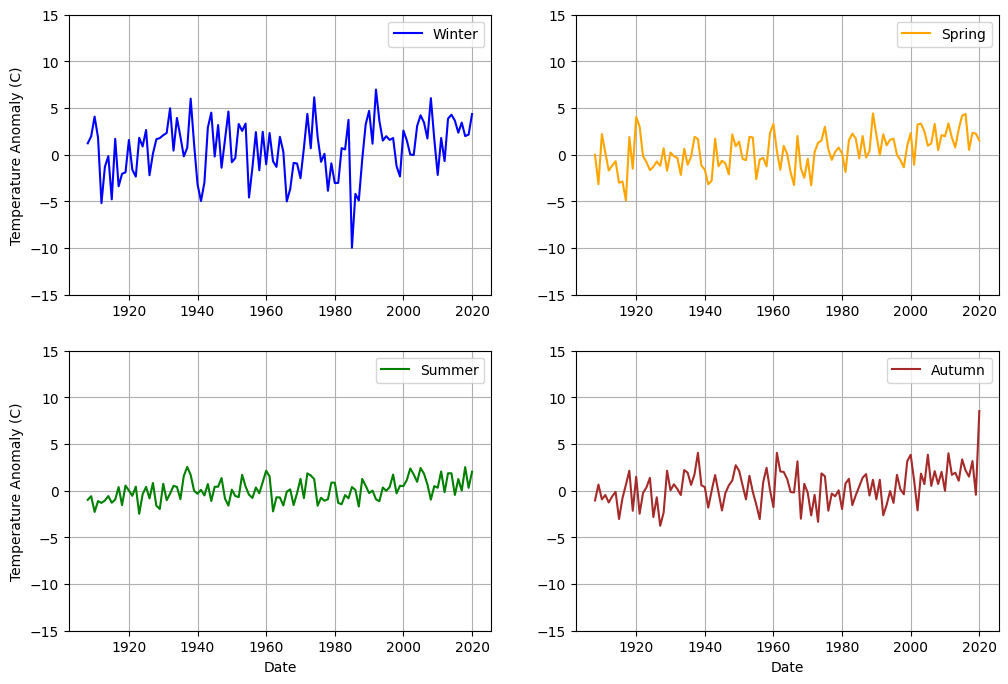

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

ax11 = axes[0][0]
ax12 = axes[0][1]
ax21 = axes[1][0]
ax22 = axes[1][1]

winter_temps_all[["YEAR", "ANOMALY"]].plot(
    ax=ax11,
    x="YEAR",
    xlabel="",
    y="ANOMALY",
    c="blue",
    ylim=[-15, 15],
    grid=True
)
spring_temps_all[["YEAR", "ANOMALY"]].plot(
    ax=ax12,
    x="YEAR",
    xlabel="",
    y="ANOMALY",
    c="orange",
    ylim=[-15, 15],
    grid=True
)
summer_temps_all[["YEAR", "ANOMALY"]].plot(
    ax=ax21,
    x="YEAR",
    xlabel="Date",
    y="ANOMALY",
    c="green",
    ylim=[-15, 15],
    grid=True
)
autumn_temps_all[["YEAR", "ANOMALY"]].plot(
    ax=ax22,
    x="YEAR",
    xlabel="Date",
    y="ANOMALY",
    c="brown",
    ylim=[-15, 15],
    grid=True
)

ax11.set_ylabel("Temperature Anomaly (C)")
ax21.set_ylabel("Temperature Anomaly (C)")
ax11.legend(["Winter"]) # set legend label
ax12.legend(["Spring"])
ax21.legend(["Summer"])
ax22.legend(["Autumn"])

